### Explore the trip data

#### read data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/OPR NLP/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/OPR NLP


In [ ]:


import pandas as pd
data = pd.read_csv('DocklessTripOpenData_201808-202001.csv')
data.head()

,TripID,StartDate,StartTime,EndDate,EndTime,TripDuration,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,DayOfWeek,HourNum
0,0000045c-2677-3a7d-4b73-cad99a57,2019-06-26,19:30,2019-06-26,19:30,3.0,0.000,38.253,-85.756,38.253,-85.755,4,19
1,0000487b-92e6-50d6-7569-42ed3818,2019-09-22,14:30,2019-09-22,14:30,5.0,0.000,38.203,-85.752,38.204,-85.751,1,14
2,00006088-2579-e0d0-6a30-a15bb878,2019-08-21,17:30,2019-08-21,17:30,6.0,0.330,38.259,-85.733,38.265,-85.739,4,17
3,00008c1a-899b-8596-970f-9f6bf495,2019-07-03,11:00,2019-07-03,11:15,6.0,0.640,38.217,-85.757,38.221,-85.763,4,11
4,00009301-3225-2aea-a84a-165a480a,2019-11-22,10:45,2019-11-22,11:00,7.0,0.599,38.215,-85.759,38.222,-85.764,6,10


#### check the date range

In [ ]:
from datetime import datetime
import dateutil.parser as dateparser
data.StartDate = [dateparser.parse(data.StartDate[i]) for i in range(len(data.StartDate))]

In [ ]:
max(data.StartDate)

Timestamp('2020-01-31 00:00:00')

In [ ]:
min(data.StartDate)

Timestamp('2018-08-09 00:00:00')

In [ ]:
# check flow by day
flowByDay = pd.DataFrame(data.StartDate.value_counts().sort_index()).reset_index()
flowByDay.head()

,index,StartDate
0,2018-08-09,295
1,2018-08-10,456
2,2018-08-11,256
3,2018-08-12,319
4,2018-08-13,167


In [ ]:
# check flow by month
flowByDay['year-month'] = [str(flowByDay['index'][i].year) +'-'+ str(flowByDay['index'][i].month).zfill(2) for i in range(len(flowByDay.index))]
flowByMonth = pd.DataFrame(flowByDay.groupby(['year-month'])['StartDate'].sum().sort_index()).reset_index()
flowByMonth

,year-month,StartDate
0,2018-08,6833
1,2018-09,13157
2,2018-10,15346
3,2018-11,17182
4,2018-12,13069
5,2019-01,11273
6,2019-02,12536
7,2019-03,19776
8,2019-04,34425
9,2019-05,50340


[Text(0, 0, '2018-08'),
 Text(0, 0, '2018-09'),
 Text(0, 0, '2018-10'),
 Text(0, 0, '2018-11'),
 Text(0, 0, '2018-12'),
 Text(0, 0, '2019-01'),
 Text(0, 0, '2019-02'),
 Text(0, 0, '2019-03'),
 Text(0, 0, '2019-04'),
 Text(0, 0, '2019-05'),
 Text(0, 0, '2019-06'),
 Text(0, 0, '2019-07'),
 Text(0, 0, '2019-08'),
 Text(0, 0, '2019-09'),
 Text(0, 0, '2019-10'),
 Text(0, 0, '2019-11'),
 Text(0, 0, '2019-12'),
 Text(0, 0, '2020-01')]

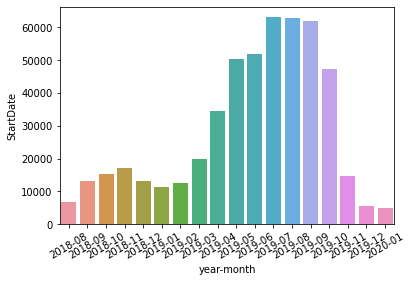

In [ ]:
import seaborn as sns
g = sns.barplot(x=flowByMonth['year-month'], y=flowByMonth['StartDate'])
g.set_xticklabels(flowByMonth['year-month'],rotation=30)

### Find last location that to pick up the vehicles

In [ ]:
def feature_engineer(data,specificDate):
  oneday = data[data.StartDate == specificDate].reset_index()
  oneday['Start_Coor'] = [(str(round(oneday.StartLatitude[i],3))+', '+str(round(oneday.StartLongitude[i],3))) for i in range(len(oneday.StartLatitude))]
  oneday['End_Coor'] = [(str(round(oneday.EndLatitude[i],3))+', '+str(round(oneday.EndLongitude[i],3))) for i in range(len(oneday.StartLatitude))]

  # lable them by time windows
  # 24 hrs, 15min is a window, then there are 24*4 = 96 timewindows
  oneday['timewindow_start'] = [int(i.split(':')[0])*4+int(i.split(':')[1])/15 for i in oneday.StartTime]
  oneday['timewindow_end'] = [int(i.split(':')[0])*4+int(i.split(':')[1])/15 for i in oneday.EndTime]
  oneday[['timewindow_start','timewindow_end']] = oneday[['timewindow_start','timewindow_end']].astype(int)

  timewindows = []
  for j in range(len(oneday.index)):
    temp=''
    if oneday.timewindow_start[j] > oneday.timewindow_end[j]:
      oneday.loc[oneday.index==j, 'timewindow_end'] = oneday.timewindow_end[j] + oneday.timewindow_start[j]

    for i in range(oneday.timewindow_start[j],oneday.timewindow_end[j]+1):
      temp += str(i)+', '
    
    timewindows.append(temp)
  oneday['timewindows'] = timewindows
  oneday = oneday.sort_values(by = 'StartTime').reset_index(drop=True)
  return oneday

In [ ]:
def distinguish_vehicle(df):
  vehicles = [[]]
  testedTripID = []
  includedTripID = []
  i=0
  while len(testedTripID) != len(df.TripID):
    testedTripID.append(df.TripID[i])

    # get rid of the includedTripID
    candidate0 = df[(df.TripID.isin(includedTripID)== False)]
    
    # get rid of the conflict time trip
    target_timewindow = df.loc[df.TripID == testedTripID[i],'timewindows'][i]
    target_timewindow = target_timewindow.replace(',','').split(' ')
    target_timewindow.remove('')
    target_timewindow = '|'.join(target_timewindow)
    # get rid of reverse sequence of time
    target_endtime = df.loc[df.TripID == testedTripID[i],'timewindow_end'][i]
    candidate1 = candidate0[(candidate0.timewindows.str.contains(target_timewindow) == False) & (candidate0.timewindow_start >= target_endtime)]

    # find same location (target End_Coor = find Start_Coor)
    target_endcoor = df.loc[df.TripID == testedTripID[i],'End_Coor'][i]
    candidate2 = candidate1[candidate1.Start_Coor == str(target_endcoor)].sort_values(by='StartTime').reset_index(drop=True)


    if candidate2.shape[0] != 0:
    # use the first candidate
    # enlarge the included Trip ID
      includedTripID.append(candidate2.TripID[0])

      # record the same vehicle
        # check if the tested trip are already in the vehicles list
      false_times = 0
      for j in range(len(vehicles)):
        if testedTripID[-1] in vehicles[j]:
          # if it exists, then enlarge the sublist
          vehicles[j].append(candidate2.TripID[0])
          # if not, then creat a new sublist to store them
        else:
          false_times += 1
      
      # if it doesn't in
      if false_times == len(vehicles):
        vehicles.append([testedTripID[-1],candidate2.TripID[0]])
    
    else:
      # check if the tested trip are already in the vehicles list
      false_times = 0
      for j in range(len(vehicles)):
        if testedTripID[-1] not in vehicles[j]:
          # if not, then creat a new sublist to store them
          false_times += 1
      
      # if it doesn't in
      if false_times == len(vehicles):
        vehicles.append([testedTripID[-1]])

    i = i + 1

  # get vehicles trip
  vehicles = vehicles[1:]
  lastTrip=[]
  for i in range(len(vehicles)):
    lastTrip.append(vehicles[i][-1])
  return lastTrip

In [ ]:
all_lastlocation = pd.DataFrame()
allDate = ['2018-9-1','2018-10-1','2018-11-1','2018-12-1','2019-1-1','2019-2-1','2019-3-1',
           '2019-4-1','2019-5-1','2019-6-1','2019-7-1','2019-8-1','2019-9-1','2019-10-1',
           '2019-11-1','2019-12-1','2020-1-1']
for specificDate in allDate:
  oneday = feature_engineer(data, specificDate)
  lastTrip = distinguish_vehicle(oneday)
  print('the number of vehicles need to be charged on ',specificDate,'is: ', len(lastTrip))
  print('the number of trips on ',specificDate,'is: ', data[data.StartDate == specificDate].shape[0])
  lastlocation = data.loc[(data.TripID.isin(lastTrip)), ['EndLatitude','EndLongitude']]
  all_lastlocation = pd.concat([all_lastlocation, lastlocation])

the number of vehicles need to be charged on  2018-9-1 is:  178
the number of trips on  2018-9-1 is:  316
the number of vehicles need to be charged on  2018-10-1 is:  314
the number of trips on  2018-10-1 is:  482
the number of vehicles need to be charged on  2018-11-1 is:  117
the number of trips on  2018-11-1 is:  143
the number of vehicles need to be charged on  2018-12-1 is:  214
the number of trips on  2018-12-1 is:  328
the number of vehicles need to be charged on  2019-1-1 is:  245
the number of trips on  2019-1-1 is:  342
the number of vehicles need to be charged on  2019-2-1 is:  162
the number of trips on  2019-2-1 is:  236
the number of vehicles need to be charged on  2019-3-1 is:  324
the number of trips on  2019-3-1 is:  582
the number of vehicles need to be charged on  2019-4-1 is:  402
the number of trips on  2019-4-1 is:  677
the number of vehicles need to be charged on  2019-5-1 is:  746
the number of trips on  2019-5-1 is:  1199
the number of vehicles need to be charg

In [ ]:
all_lastlocation.to_csv('20180901_20190101_allLocation.csv',index=False)

In [ ]:
all_lastlocation.shape

(8655, 2)